In [2]:
!pip install pytorch-lightning
!pip install torchvision
!pip install matplotlib
!pip install datasets
!pip install wandb
!pip install --upgrade ipywidgets
!pip install pyyaml

In [6]:
from pytorch_lightning.loggers import WandbLogger
from kaggle_secrets import UserSecretsClient
import wandb
import os

secret_label = "wand_token"
secret_value = UserSecretsClient().get_secret(secret_label)

os.environ["WANDB_API_KEY"] = secret_value

wandb_logger = WandbLogger(project="animation_types")

wandb.login()

True

In [3]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torchmetrics
from torchvision.datasets import ImageFolder
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import torch
import numpy as np
from datasets import load_dataset
from torchvision.transforms import v2
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights
# from torchvision.models import efficientnet_b6, EfficientNet_B6_Weights
from torchvision.models import vgg16, VGG16_Weights
from torchvision.models import efficientnet_v2_l, EfficientNet_V2_L_Weights
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights 
from pytorch_lightning.loggers import WandbLogger
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

In [50]:
class AnimationTypesDatamodule(pl.LightningDataModule):
  def __init__(self, batch_size = 32):
    super().__init__()
    self.batch_size = batch_size
  def setup(self, stage = None):
    transform = v2.Compose([
                        # v2.To
                        v2.ToImage(),
                        v2.Resize(256),
                        v2.CenterCrop(224),
                        v2.RandomHorizontalFlip(p=0.5),
                        v2.RandomRotation(30),
                        v2.RandomVerticalFlip(p=0.5),
                        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                        v2.ToDtype(torch.float32, scale=True), # v2.ToTensor()
                        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ])


    transform_vt = v2.Compose([
                        v2.ToImage(),
                        v2.Resize(256),
                        v2.CenterCrop(224),
                        v2.ToDtype(torch.float32, scale=True),
                        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ])


    def transforms(examples):
        examples["pixel_values"] = [transform(img.convert("RGB")) for img in examples["image"]]
        del examples["image"]
        return examples

    def transforms_vt(examples):
        examples["pixel_values"] = [transform_vt(img.convert("RGB")) for img in examples["image"]]
        del examples["image"]
        return examples

    dataset = load_dataset("krowiemlekommm/ANIMATION_TYPES_3.0")

    self.train_dataset = dataset["train"].with_transform(transforms)
    self.test_dataset = dataset["test"].with_transform(transforms_vt)
    self.val_dataset = dataset["validation"].with_transform(transforms_vt)

  def train_dataloader(self):
    return  DataLoader(self.train_dataset, num_workers = 4, batch_size = self.batch_size, shuffle = True)
  def test_dataloader(self):
    return  DataLoader(self.test_dataset, num_workers = 4, batch_size = self.batch_size, shuffle = False)
  def val_dataloader(self):
    return  DataLoader(self.val_dataset, num_workers = 4, batch_size = self.batch_size, shuffle = False)

(Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False),)

In [13]:
dm = AnimationTypesDatamodule()

In [14]:
dm.setup()

README.md:   0%|          | 0.00/683 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/231M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/58.5M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/46.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4966 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1027 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1100 [00:00<?, ? examples/s]

In [11]:
dm.train_dataset[0]

{'label': 0,
 'pixel_values': Image([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8

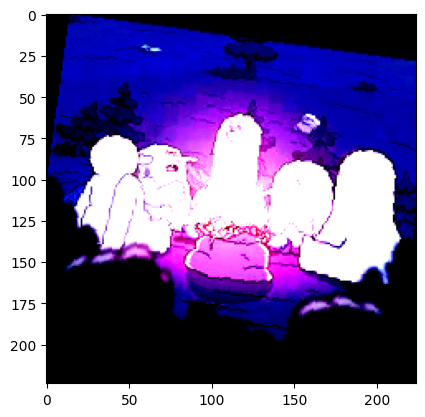

In [12]:
img = dm.train_dataset[0]["pixel_values"]
img = img.permute(1, 2, 0)
plt.imshow(img)

In [15]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl
import torchmetrics
import torch.nn as nn

class MovieFrame(pl.LightningModule):
    def __init__(self, layer1_size, dropout_rate, lr, num_classes=4):
        super().__init__()
        self.model = models.efficientnet_b0(weights = EfficientNet_B0_Weights.IMAGENET1K_V1) 
        self.backbone = self.model.features
        self.pooling = self.model.avgpool
        self.dropout = nn.Dropout(p=dropout_rate, inplace=True)
        self.fc1 = nn.Linear(1280 , layer1_size)
        self.fc2 = nn.Linear(layer1_size, num_classes)
        self.lr = lr
        self.loss_function = nn.CrossEntropyLoss()

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

        self.train_macro_f1 = torchmetrics.F1Score(num_classes=num_classes, task="multiclass", average='macro')
        self.val_macro_f1 = torchmetrics.F1Score(num_classes=num_classes, task="multiclass", average='macro')
        self.test_f1 = torchmetrics.F1Score(num_classes=num_classes, task="multiclass", average='macro')
        

        self.train_macro_recall = torchmetrics.Recall(num_classes=num_classes, task="multiclass", average='macro')
        self.val_macro_recall = torchmetrics.Recall(num_classes=num_classes, task="multiclass", average='macro')

        self.train_macro_precision = torchmetrics.Precision(num_classes=num_classes, task="multiclass", average='macro')
        self.val_macro_precision = torchmetrics.Precision(num_classes=num_classes, task="multiclass", average='macro')

        
        for param in self.backbone.parameters():
            param.requires_grad = False

    def forward(self, x):
      self.backbone.eval()
      with torch.no_grad():
          x = self.backbone(x)
          x = self.pooling(x).flatten(1)
      x = self.dropout(x)
      x = F.relu(x)
      x = self.fc1(x)
      x = self.dropout(x)
      x = F.relu(x)
      x = self.fc2(x)

      return x
    

    def configure_optimizers(self):
      optimizer =  optim.Adam(self.parameters(), lr=self.lr)
      return optimizer

    def training_step(self, train_batch, batch_idx):
      inputs, labels = train_batch["pixel_values"], train_batch["label"]


      outputs = self.forward(inputs.float())
      loss = self.loss_function(outputs, labels)


      self.log('train_loss', loss, on_step = True, on_epoch = True)

      outputs = F.softmax(outputs, dim =1)

      self.train_acc(outputs, labels)
      self.log('train_acc', self.train_acc, on_epoch=True, on_step= False)

      self.train_macro_f1(outputs, labels)
      self.log('train_macro_f1', self.train_macro_f1, on_epoch=True, on_step= False)

      self.train_macro_recall(outputs, labels)
      self.log('train_macro_recall', self.train_macro_recall, on_epoch=True, on_step= False)

      self.train_macro_precision(outputs, labels)
      self.log('train_macro_precision', self.train_macro_precision, on_epoch=True, on_step= False)



      return loss

    def validation_step(self, val_batch, batch_idx):
      inputs, labels = val_batch["pixel_values"], val_batch["label"]

      outputs = self.forward(inputs.float())
      loss = self.loss_function(outputs, labels)

      self.log('val_loss', loss,  on_step= True, on_epoch = True, sync_dist=True)

      outputs = F.softmax(outputs, dim =1)

      self.val_acc(outputs, labels)
      self.log('val_acc', self.val_acc, on_epoch=True, on_step= False)

      self.val_macro_f1(outputs, labels)
      self.log('val_macro_f1', self.val_macro_f1, on_epoch=True, on_step= False)

      self.val_macro_recall(outputs, labels)
      self.log('val_macro_recall', self.val_macro_recall, on_epoch=True, on_step= False)

      self.val_macro_precision(outputs, labels)
      self.log('val_macro_precision', self.val_macro_precision, on_epoch=True, on_step= False)

      return loss


    def test_step(self, batch, batch_idx):
        inputs, labels = batch["pixel_values"], batch["label"]
        outputs = self.forward(inputs.float())
        
        loss = self.loss_function(outputs, labels)
        self.log("test_loss", loss)

        self.test_acc(outputs, labels)
        self.log('test_acc', self.test_acc)
        
        self.test_f1(outputs, labels)
        self.log('test_f1', self.test_f1)

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        inputs = batch["pixel_values"]
        logits = self(inputs.float())
        probabilities = F.softmax(logits, dim=1)
        return probabilities

In [14]:
# from pytorch_lightning.strategies import DDPStrategy
# from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# num_classes = 4
# model = MovieFrame(num_classes = num_classes,
#                   layer1_size = 256,
#                   dropout_rate = 0.7,
#                   lr = 0.00022838551102598225)
# logger = TensorBoardLogger("lightning_logs", name="animation_model")
# trainer = pl.Trainer(accelerator = "gpu",
#                      devices=1,
#                      logger=wandb_logger,
#                      max_epochs = 30,
#                     )

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:01<00:00, 195MB/s] 


In [ ]:
# trainer.fit(model, dm)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# wandb.finish()

In [5]:
!pwd /kaggle/input/moveframe/other/default/1/model.ckpt

/kaggle/working


In [31]:
import yaml
HP_PATH = "/kaggle/input/idkwhyits/config.yaml"
with open(HP_PATH, "r") as file:
    config = yaml.safe_load(file)

In [36]:
config

{'_wandb': {'value': {'cli_version': '0.19.1',
   'm': [],
   'python_version': '3.10.12',
   't': {'1': [1, 9, 11, 41, 49, 51, 55, 103],
    '2': [1, 9, 11, 41, 49, 51, 55, 103],
    '3': [2, 14, 17, 23, 55],
    '4': '3.10.12',
    '5': '0.19.1',
    '6': '4.44.2',
    '8': [1, 2, 5, 12],
    '12': '0.19.1',
    '13': 'linux-x86_64'}}},
 'batch_size': {'value': 64},
 'dropout_rate': {'value': 0.7},
 'layer1_size': {'value': 256},
 'learning_rate': {'value': 0.00022838551102598225},
 'n_epochs': {'value': 20}}

In [44]:
CKPT_PATH = "/kaggle/input/moveframe/other/default/1/model.ckpt"

model = MovieFrame.load_from_checkpoint(CKPT_PATH,
                                        num_classes = 4,
                                        layer1_size = 256,
                                        dropout_rate = 0.7,
                                        lr = 0.00022838551102598225)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 168MB/s]


In [45]:
datamodule = AnimationTypesDatamodule(batch_size=32)
datamodule.setup()

trainer = pl.Trainer()
predictions = trainer.predict(model, dataloaders=datamodule.test_dataloader())

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/tmp/ipykernel_30/2701358265.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  metric.update(torch.tensor(predicted_labels), torch.tensor(true_labels))


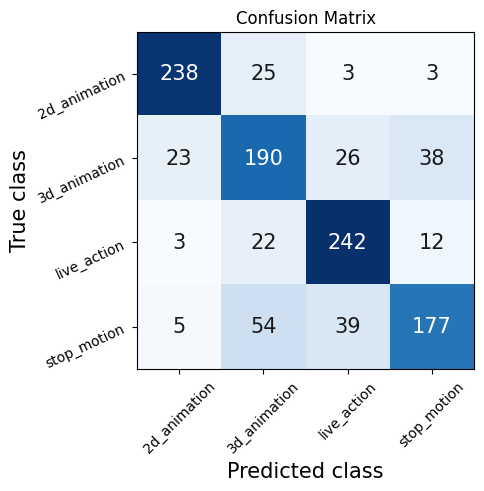

In [47]:
from torchmetrics.classification import MulticlassConfusionMatrix

label_names = dm.train_dataset.features["label"].names

predicted_labels = []
true_labels = [] 

for pred in predictions:
    predicted_labels.extend(pred.cpu().numpy())

for batch in datamodule.test_dataloader():
    true_labels.extend(batch["label"].cpu().numpy())
    
metric = MulticlassConfusionMatrix(num_classes=4)

metric.update(torch.tensor(predicted_labels), torch.tensor(true_labels))

import matplotlib.pyplot as plt

fig, ax = metric.plot(cmap="Blues")

ax.set_xticklabels(label_names, rotation=45)
ax.set_yticklabels(label_names)

plt.title("Confusion Matrix")
plt.show()